#  Movie recommendation Syetem


## **Import Libraries**

In [104]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNBasic, Reader
from surprise import Dataset,accuracy
from surprise.model_selection import train_test_split
import time

## **Read Data**

#### **These files contain 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.**

In [105]:
movies_data = pd.read_csv("movies.csv",delimiter=";",encoding='latin-1')

In [106]:
ratings_data = pd.read_csv("ratings.csv",delimiter=";",encoding='latin-1')

In [107]:
user_data = pd.read_csv("users.csv",delimiter=";",encoding='latin-1')

##  **Exploratory Data Analysis**


In [108]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movieId     3883 non-null   object
 1   title       3882 non-null   object
 2   genres      2919 non-null   object
 3   Unnamed: 3  1 non-null      object
dtypes: object(4)
memory usage: 121.5+ KB


#### **Genres are pipe-separated and are selected from the following genres:**

	Action
	Adventure
	Animation
	Children's
	Comedy
	Crime
	Documentary
	Drama
	Fantasy
	Film-Noir
	Horror
	Musical
	Mystery
	Romance
	Sci-Fi
	Thriller
	War
	Western

In [109]:
movies_data.head()

,movieId,title,genres,Unnamed: 3
0,1,Toy Story (1995),Animation|Children's|Comedy,NaN
1,2,Jumanji (1995),Adventure|Children's|Fantasy,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN


In [110]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [111]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [112]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [113]:
user_data.head()

,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,2460
4,5,M,25,20,55455


#### **Gender is denoted by a "M" for male and "F" for female**

In [114]:
user_data['gender'].value_counts()

M    4331
F    1709
Name: gender, dtype: int64

#### **Age is chosen from the following ranges:**

	 1:  "Under 18"
     18:  "18-24"
	 25:  "25-34"
     35:  "35-44"
	 45:  "45-49"
     50:  "50-55"
     56:  "56+"

In [115]:
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

#### **Occupation is chosen from the following choices:**

	  0:  "other" or not specified
	  1:  "academic/educator"
      2:  "artist"
	  3:  "clerical/admin"
	  4:  "college/grad student"
	  5:  "customer service"
	  6:  "doctor/health care"
	  7:  "executive/managerial"
	  8:  "farmer"
	  9:  "homemaker"
	 10:  "K-12 student"
	 11:  "lawyer"
	 12:  "programmer"
	 13:  "retired"
	 14:  "sales/marketing"
	 15:  "scientist"
	 16:  "self-employed"
	 17:  "technician/engineer"
	 18:  "tradesman/craftsman"
	 19:  "unemployed"
	 20:  "writer"

In [116]:
user_data['occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: occupation, dtype: int64

##  **PreProcessing**

In [117]:
movies_data.head()

,movieId,title,genres,Unnamed: 3
0,1,Toy Story (1995),Animation|Children's|Comedy,NaN
1,2,Jumanji (1995),Adventure|Children's|Fantasy,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN


In [118]:
# WE try to split year of movie from title column

In [119]:
def date_catch(txt):
    x=0
    try:
        txt.strip()
        x=int(txt[-5:-1])
    except:
        x=0
    return x

In [120]:
def data_tilte(txt):
    x=0
    outp=""
    try:
        txt.strip()
        x=int(txt[-5:-1])
        outp=txt[:-6]
    except:
        x=0
        outp=txt
    return outp

In [121]:
movies_data['date']=movies_data['title'].apply(date_catch)

In [122]:
movies_data.head(5)

,movieId,title,genres,Unnamed: 3,date
0,1,Toy Story (1995),Animation|Children's|Comedy,NaN,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,NaN,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,NaN,1995
4,5,Father of the Bride Part II (1995),Comedy,NaN,1995


In [123]:
movies_data.shape

(3883, 5)

In [124]:
movies_data[movies_data['date']==0]

,movieId,title,genres,Unnamed: 3,date
10,11,American President,NaN,NaN,0
11,12,Dracula,Dead and Loving It (1995),NaN,0
18,19,Ace Ventura,When Nature Calls (1995),NaN,0
28,29,City of Lost Children,NaN,NaN,0
39,40,Cry,NaN,NaN,0
...,...,...,...,...,...
3861,3945,Digimon,The Movie (2000),NaN,0
3868,3952,Contender,NaN,NaN,0
3876,2886,Adventures of Elmo in Grouchland,NaN,NaN,0
3879,2889,Mystery,NaN,NaN,0


#### **it's sperated in good way and format but we noticed that there are more that 1000 movie without public date so we decide to remove publish date from our data**


In [125]:
movies_data['title']=movies_data['title'].apply(data_tilte)

In [126]:
movies_data

,movieId,title,genres,Unnamed: 3,date
0,1,Toy Story,Animation|Children's|Comedy,NaN,1995
1,2,Jumanji,Adventure|Children's|Fantasy,NaN,1995
2,3,Grumpier Old Men,Comedy|Romance,NaN,1995
3,4,Waiting to Exhale,Comedy|Drama,NaN,1995
4,5,Father of the Bride Part II,Comedy,NaN,1995
...,...,...,...,...,...
3878,2888,Drive Me Crazy,Comedy|Romance,NaN,1999
3879,2889,Mystery,NaN,NaN,0
3880,2890,Three Kings,Drama|War,NaN,1999
3881,2891,Happy,NaN,NaN,0


In [127]:
movies_data.drop(['Unnamed: 3','date'],axis=1,inplace=True)

In [128]:
 movies_data.head()

,movieId,title,genres
0,1,Toy Story,Animation|Children's|Comedy
1,2,Jumanji,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama
4,5,Father of the Bride Part II,Comedy


In [129]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   object
 1   title    3882 non-null   object
 2   genres   2919 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


#### **we should drop all rows with null values in genres and title**

In [130]:
movies_data.dropna(inplace=True)

In [131]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  2919 non-null   object
 1   title    2919 non-null   object
 2   genres   2919 non-null   object
dtypes: object(3)
memory usage: 91.2+ KB


#### **Remove all genres records that not exist in our unique genres values**

In [132]:
def label_genres(txt):
    txt=txt.lower()
    
    gen_list=['action','adventure','animation',"children's",'comedy','crime','documentary',\
'drama','fantasy','film-noir','horror','musical','romance','sci-fi','thriller','western','war']
    
    if any(gen in txt for gen in gen_list):
        return 1
    else:
        return 0
            

In [133]:
movies_data['check_gen']=movies_data['genres'].apply(label_genres)

In [134]:
movies_data['check_gen'].value_counts()

1    2728
0     191
Name: check_gen, dtype: int64

In [135]:
movies_data[movies_data['check_gen']==0]

,movieId,title,genres,check_gen
11,12,Dracula,Dead and Loving It (1995),0
18,19,Ace Ventura,When Nature Calls (1995),0
65,66,Lawnmower Man 2,Beyond Cyberspace (1996),0
97,99,Heidi Fleiss,Hollywood Madam (1995),0
163,165,Die Hard,With a Vengeance (1995),0
...,...,...,...,...
3805,3889,Highlander,Endgame (2000),0
3824,3908,Urban Legends,Final Cut (2000),0
3834,3918,Hellbound,Hellraiser II (1988),0
3835,3919,Hellraiser III,Hell on Earth (1992),0


In [136]:
movies_data=movies_data[movies_data['check_gen']==1]

In [137]:
movies_data.shape

(2728, 4)

In [138]:
movies_data.drop(['check_gen'],axis=1,inplace=True)

C:\Users\moham\AppData\Local\Temp\ipykernel_2892\1358721156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_data.drop(['check_gen'],axis=1,inplace=True)


In [139]:
movies_data

,movieId,title,genres
0,1,Toy Story,Animation|Children's|Comedy
1,2,Jumanji,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama
4,5,Father of the Bride Part II,Comedy
...,...,...,...
3875,2885,Guinevere,Drama|Romance
3877,2887,Simon Sez,Drama
3878,2888,Drive Me Crazy,Comedy|Romance
3880,2890,Three Kings,Drama|War


In [140]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [141]:
ratings_data['rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

In [142]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [143]:
val=ratings_data.groupby(['movieId','rating']).agg({'rating':['count']})


In [144]:
data=pd.DataFrame(val)

In [145]:
data=data.reset_index()

In [146]:
data.columns=['movieId','rating','count']

In [147]:
data

,movieId,rating,count
0,1,1,16
1,1,2,61
2,1,3,345
3,1,4,835
4,1,5,820
...,...,...,...
16907,3952,1,9
16908,3952,2,26
16909,3952,3,89
16910,3952,4,181


In [148]:
movie_id=[]
movie_rate=[]
for i in data['movieId'].unique():
    movie_id.append(i)
   
    review_count_sum=0
    review_cal_count=0
    for j in range(1,6):
        temp=data[(data['movieId']==i) & (data['rating']==j)]
        if temp.shape[0] !=0:
            review_count_sum+=int(temp['count'].values[0])
            review_cal_count+=int(temp['count'].values[0])*j
        
    movie_rate.append(round((review_cal_count/review_count_sum),1))

In [149]:
movie_id[:5]

[1, 2, 3, 4, 5]

In [150]:
movie_rate[:5]

[4.1, 3.2, 3.0, 2.7, 3.0]

In [151]:
def rate(movie_d):
    movie_d=int(movie_d)
    try:
        index=movie_id.index(movie_d)
        return movie_rate[index]
    except:
        return 0
    

In [152]:
movies_data['rate']=movies_data['movieId'].apply(rate)

C:\Users\moham\AppData\Local\Temp\ipykernel_2892\3260656707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_data['rate']=movies_data['movieId'].apply(rate)


In [153]:
movies_data.to_csv("final_movie_data.csv",index=False)

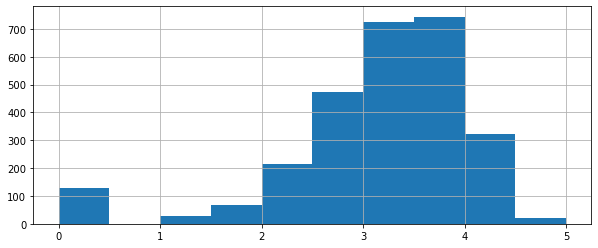

In [154]:
plt.figure(figsize=(10,4))
movies_data['rate'].hist()
plt.show()

## **Recommendation System using Content Based Filtering**

In [155]:
movies_data

,movieId,title,genres,rate
0,1,Toy Story,Animation|Children's|Comedy,4.1
1,2,Jumanji,Adventure|Children's|Fantasy,3.2
2,3,Grumpier Old Men,Comedy|Romance,3.0
3,4,Waiting to Exhale,Comedy|Drama,2.7
4,5,Father of the Bride Part II,Comedy,3.0
...,...,...,...,...
3875,2885,Guinevere,Drama|Romance,3.4
3877,2887,Simon Sez,Drama,2.2
3878,2888,Drive Me Crazy,Comedy|Romance,2.8
3880,2890,Three Kings,Drama|War,3.8


In [156]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
genres = vectorizer.fit_transform(movies_data.genres).toarray()
contents = pd.DataFrame(genres,columns=vectorizer.get_feature_names())
print('Shape of the content table :',contents.shape)
contents.head()

Shape of the content table : (2728, 22)


C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,action,adventure,animation,children,comedy,crime,documentary,drama,dream,fantasy,...,horror,musical,mystery,noir,romance,sci,thriller,war,warriors,western
0,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
contents.columns

Index(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'dream', 'fantasy', 'fi', 'film', 'horror',
       'musical', 'mystery', 'noir', 'romance', 'sci', 'thriller', 'war',
       'warriors', 'western'],
      dtype='object')

In [158]:
contents.to_csv('final_contents.csv',index=False)

In [159]:
from sklearn.neighbors import NearestNeighbors
nearset = NearestNeighbors(metric='cosine')
nearset.fit(contents)

NearestNeighbors(metric='cosine')

In [160]:
import pickle 
knnPickle = open('knnpickle_file_content.pkl', 'wb') 
      
# source, destination 
pickle.dump(nearset, knnPickle)  

# close the file
knnPickle.close()
                

In [161]:
with open('knnpickle_file_content.pkl', 'rb') as file:
    knn_model=pickle.load(file)

In [170]:
def recommend_on_movie_content_based(movie,n_reccomend = 5):
    print(movie)
   
    input_movie_index=movies_data[movies_data['title'].str.strip()==movie].index[0]
    input_movie_generes=contents.iloc[input_movie_index]
    print(input_movie_index) 
    print(input_movie_generes)
    _,neighbors=knn_model.kneighbors([input_movie_generes],n_neighbors=n_reccomend+1)
    
    recommeds_movies=[]
    recommends_rate=[]
    for i in neighbors[0]:
        if i !=input_movie_index:
            recommeds_movies.append(movies_data.iloc[i]['title'])
            recommends_rate.append((movies_data.iloc[i]['rate']))
    #sort based on movies rates 
    recommends_rate,recommeds_movies= zip(*sorted(zip(recommends_rate,recommeds_movies)))
    
    
    
    return [recommeds_movies[-1-i]+'- '+str(recommends_rate[-1-i]) for i in range(0,n_reccomend)]

In [171]:
data=pd.read_csv('final_movie_data.csv',encoding='latin-1')

In [172]:
data_contents=pd.read_csv('final_contents.csv',encoding='latin-1')

In [173]:
recommend_on_movie_content_based('Father of the Bride Part II')

Father of the Bride Part II
4
action         0
adventure      0
animation      0
children       0
comedy         1
crime          0
documentary    0
drama          0
dream          0
fantasy        0
fi             0
film           0
horror         0
musical        0
mystery        0
noir           0
romance        0
sci            0
thriller       0
war            0
warriors       0
western        0
Name: 4, dtype: int64


C:\Users\moham\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


['Being John Malkovich - 4.1',
 'Crimes and Misdemeanors - 4.0',
 'Dazed and Confused - 3.7',
 'Fatal Instinct - 2.6',
 "Krippendorf's Tribe - 2.4"]

## **Recommendation System using Collaborative Filtering**

In [166]:
rating_pivot = ratings_data.pivot_table(values='rating',columns='userId',index='movieId').fillna(0)
print('Shape of this pivot table :',rating_pivot.shape)
rating_pivot.head()

Shape of this pivot table : (3706, 6040)


userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [167]:
from sklearn.neighbors import NearestNeighbors
nearset = NearestNeighbors(metric='cosine')
nearset.fit(rating_pivot)

NearestNeighbors(metric='cosine')

In [168]:
def recommend_on_movie_collaborative_based(movie,n_reccomend = 5):
    input_movie_id=int(movies_data[movies_data['title'].str.strip()==movie]['movieId'])
    input_movie_rating=rating_pivot.iloc[input_movie_id]
    
    v,neighbors=nearset.kneighbors([input_movie_rating],n_neighbors=n_reccomend+1)
    
    recommeds_movies=[]
    recommends_rate=[]
    for i in neighbors[0]:
        if i !=input_movie_id:
            recommeds_movies.append(movies_data.iloc[i]['title'])
            recommends_rate.append((movies_data.iloc[i]['rate']))
    
    print(recommeds_movies)
    print(recommends_rate)
    
    recommends_rate,recommeds_movies= zip(*sorted(zip(recommends_rate,recommeds_movies)))

    return [recommeds_movies[-1-i]+'- '+str(recommends_rate[-1-i]) for i in range(0,n_reccomend)]

In [169]:
recommend_on_movie_collaborative_based('Father of the Bride Part II')

["Where's Marlowe? ", 'Pinocchio ', 'Lamerica ', 'Asfour Stah ', 'Ratchet ']
[4.0, 3.8, 4.8, 0.0, 0.0]


['Lamerica - 4.8',
 "Where's Marlowe? - 4.0",
 'Pinocchio - 3.8',
 'Ratchet - 0.0',
 'Asfour Stah - 0.0']